<a href="https://colab.research.google.com/github/Voland24/ModernComputerVisionPytorch/blob/main/BuildingANeuralNetPytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
x = [[1,2],[3,4],[5,6],[7,8]] #input values
y = [[3],[7],[11],[15]] #output values

#trying to teach it addition

X = torch.tensor(x).float()
Y = torch.tensor(y).float()

#Good practice to have tensors as floats or long ints

device = 'cuda' if torch.cuda.is_available() else 'cpu'

#transfer the tensors to the GPU mem
X = X.to(device)
Y = Y.to(device)



Defining a class to represent out NN model. We inherit the nn.MOdule class for all the functionalities neccessary.
torch.nn offers various helpful functions built-in

In [3]:
class MyNeuralNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.input_to_hidden_layer = nn.Linear(2,8) #lineal layer w*x + b with 2 inputs and 8 outputs
    self.hidden_layer_activation = nn.ReLU()
    self.hidden_to_output_layer = nn.Linear(8,1) #same thing 8 ins and 1 out
  def forward(self, x):
    x = self.input_to_hidden_layer(x)
    x = self.hidden_layer_activation(x)
    x = self.hidden_to_output_layer(x)
    return x
    

Create our model and send it to the GPU memory

In [27]:
#torch.manual_seed(0) #keeps the weights initialized the same random way for each iter in the same runtime
mynet = MyNeuralNet().to(device)

Just a sidenote, we can access the weights of the layers like so

In [28]:
print(mynet.input_to_hidden_layer.weight)

Parameter containing:
tensor([[-0.3255, -0.4940],
        [-0.6622, -0.4128],
        [ 0.6078,  0.3155],
        [ 0.3427,  0.0372],
        [-0.3625,  0.1196],
        [-0.6602, -0.5109],
        [-0.3645,  0.4461],
        [ 0.4146, -0.3136]], device='cuda:0', requires_grad=True)


We are predicting a continious output i.e. a regression problem, so we can choose our output function to be the MeanSquaredErrorLoss


In [29]:
loss_func = nn.MSELoss()

How to use and calculate the loss function value?

In [30]:
_Y = mynet(X)
loss_value = loss_func(_Y,Y) #torch convention, always send in form (prediction, ground_truth)
print(loss_value)

tensor(112.4196, device='cuda:0', grad_fn=<MseLossBackward0>)


Just a sidenote, how to see the model parameters

In [14]:
for param in mynet.parameters():
  print(param)

Parameter containing:
tensor([[-0.0053,  0.3793],
        [-0.5820, -0.5204],
        [-0.2723,  0.1896],
        [-0.0140,  0.5607],
        [-0.0628,  0.1871],
        [-0.2137, -0.1390],
        [-0.6755, -0.4683],
        [-0.2915,  0.0262]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([ 0.2795,  0.4243, -0.4794, -0.3079,  0.2568,  0.5872, -0.1455,  0.5291],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[-0.0570,  0.0374,  0.3201, -0.3280, -0.2226, -0.0895, -0.1378,  0.3055]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-0.2292], device='cuda:0', requires_grad=True)


Now we have the neural net and the loss func, we have to define the optimizer that we will use to reduce the loss error value

In [31]:
from torch.optim import SGD
opt = SGD(mynet.parameters(), lr = 0.001)

The training process is as follows:

1.   We flushg the previous epochs grads
2.   we compute the loss function on the current params
3. we perform the backpass
4. we update the params based on their grads





In [32]:
loss_history = []
for _ in range(50): #number of epochs is 50
  opt.zero_grad() #flush the prev grads
  loss_value = loss_func(mynet(X), Y) #calc the loss func
  loss_value.backward() #the backpass
  opt.step() #calculate and update the grads of all the weights and biases
  loss_history.append(loss_value)

print(type(loss_history))

<class 'list'>


In [45]:

val_x = [[10,11]]

val_x = torch.tensor(val_x).float().to(device)

mynet(val_x)

tensor([[20.5834]], device='cuda:0', grad_fn=<AddmmBackward0>)

Plot the loss over epoch graph to see if the model is learning

Text(0, 0.5, 'Loss func value')

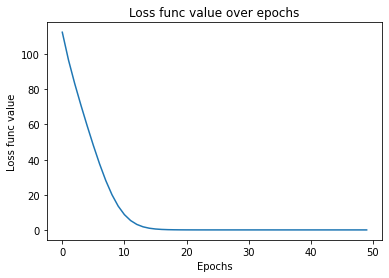

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(torch.tensor(loss_history).detach().numpy())
plt.title('Loss func value over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss func value')

We can see the model is learning and that the loss function is approaching 0 asa the epochs  go on

# **Batch size and dataloaders**

Batch size is an important part of designing a NN to consider and it's a hyperparameter. It describes just how many datapoint will we use to calculate the gradients i.e the loss value and update the params in a backpass

This comes to prominence especially when we consider datasets to have several milion datapoints and running GD on all of them every time we want to calculate the gradients is going to be very slow, although very precise. 
We will use the batch to retreive a representative sample of the data that is going to be a good enough of a approximation of the whole dataset.


In [37]:
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
  def __init__(self, x, y):
    self.x = x.clone().detach().requires_grad_(True)#torch.tensor(x).float()
    self.y = y.clone().detach().requires_grad_(True)
  def __len__(self):
    return len(self.x)
  def __getitem__(self, index):
    return self.x[index], self.y[index]  #fetching the 'index' row of both datasets

In [38]:
ds = MyDataset(X, Y)

We can use the DataLoader class to easily fetch a specifed size or batch of examples from the given dataset

In [39]:
d1 = DataLoader(ds, batch_size = 2, shuffle = True) #shuffle just means that the examples in the batch are randomly chosen


Example of usage

In [40]:
for x, y in d1:
  print(x,y)

tensor([[5., 6.],
        [1., 2.]], device='cuda:0', grad_fn=<StackBackward0>) tensor([[11.],
        [ 3.]], device='cuda:0', grad_fn=<StackBackward0>)
tensor([[7., 8.],
        [3., 4.]], device='cuda:0', grad_fn=<StackBackward0>) tensor([[15.],
        [ 7.]], device='cuda:0', grad_fn=<StackBackward0>)


Now we are going to train the NN again, this time using batch GD, meaning we will perform more tham one update per epoch, epoch being looping through the entire dataset once, and we are updating per batch

In the example given above, we performed the updates on batch size = 4 i.e the entire dataset per epoch i.e once per epoch.
Here the batch size is 2 meaning we have 2X updates per epoch

In [42]:
import time
loss_history = []
start = time.time()
for _ in range(50):
  for data in d1:
    x,y = data
    opt.zero_grad()
    loss_value = loss_func(mynet(x), y)
    loss_value.backward()
    opt.step()
    loss_history.append(loss_value)
end = time.time()
print(end - start)

0.11580109596252441


How to predict new values?

In [44]:
#create a test example

val_x = [[10,11]]

val_x = torch.tensor(val_x).float().to(device)

mynet(val_x)

tensor([[20.5834]], device='cuda:0', grad_fn=<AddmmBackward0>)

# **Custom loss functions**

Somtimes there is a need to define custom loss functions, tailored to our specific problem. This is the case with GANs or object detection problems etc.

We will implement and use the MSE loss 

In [47]:
def my_mean_squared_error(_y, y):
  loss = (_y - y) ** 2
  loss = loss.mean()
  return loss

#sanity scheck

print(loss_func(mynet(X), Y))
print(my_mean_squared_error(mynet(X), Y))

tensor(0.0433, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0433, device='cuda:0', grad_fn=<MeanBackward0>)


# **Looking at hidden layers outputs**

This will come in handy in transfer learning, for example looking the output of the CNN layer, the last layer and extracting its feature mapping of the input values i.e image.


In [48]:
#We can call them like functions

input_to_hidden = mynet.input_to_hidden_layer(X)
hidden_activation = mynet.hidden_layer_activation(input_to_hidden)

print(hidden_activation)

tensor([[ 0.0000,  0.0000,  2.4913,  1.6628,  0.0000,  0.0000,  0.5450,  0.6073],
        [ 0.0000,  0.0000,  5.0791,  3.6700,  0.0000,  0.0000,  1.2647,  1.6914],
        [ 0.0000,  0.0000,  7.6668,  5.6772,  0.0000,  0.0000,  1.9844,  2.7755],
        [ 0.0000,  0.0000, 10.2546,  7.6845,  0.0000,  0.0000,  2.7041,  3.8595]],
       device='cuda:0', grad_fn=<ReluBackward0>)


Or we can add in the forward method of the neural net to return not only the last output but however many outputs we want from whatever layers we choose